In [31]:
import pandas as pd
from sklearn.metrics import cohen_kappa_score
from itertools import combinations
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

In [32]:
df = pd.read_pickle('data.pkl')
pd.set_option('display.max_rows', 200)

In [33]:
df_base = df[['text','start_char','end_char']].copy().drop_duplicates().reset_index()
for nlp in df['nlp'].unique():
    nlp_type_column = f'{nlp}_type'
    df_base = pd.merge(left=df_base, right=df.query(f'nlp == "{nlp}"'), how='left', on=['text','start_char','end_char'])
    df_base.drop('nlp', axis=1, inplace=True)
    df_base.rename(columns={'type':nlp_type_column}, inplace=True)

df_base.loc[df_base['FastPDN_type']=='nam_loc_gpe_country','FastPDN_type'] = 'placeName'
df_base.loc[df_base['FastPDN_type']=='nam_org_company','FastPDN_type'] = 'orgName'
df_base.loc[df_base['FastPDN_type']=='nam_org_organization','FastPDN_type'] = 'orgName'
df_base.loc[df_base['FastPDN_type']=='nam_liv_person','FastPDN_type'] = 'persName'

In [34]:
df_base.head(20)

,index,text,start_char,end_char,Stanza-Default_type,Spacy-Default_type,FastPDN_type
0,0,28 grudnia 2023 r.,323,341,date,date,NaN
1,1,27 grudnia 2023 r.,368,386,date,date,NaN
2,2,Spółka,460,466,orgName,orgName,NaN
3,3,DFG,571,574,orgName,orgName,NaN
4,4,"„WFS""",762,767,orgName,NaN,NaN
5,5,Niemiec,857,864,placeName,placeName,placeName
6,6,Niemczech,940,949,placeName,placeName,placeName
7,7,"„Grupa""",1023,1030,orgName,NaN,NaN
8,8,Rzeczypospolitej Polskiej,1216,1241,placeName,placeName,placeName
9,9,Polsce,1293,1299,placeName,placeName,placeName


In [35]:
tool_columns = ['Stanza-Default_type', 'Spacy-Default_type', 'FastPDN_type']

In [36]:
def calculate_pairwise_kappa(df, tool_columns):
    kappa_scores = {}
    for tool1, tool2 in combinations(tool_columns, 2):
        # Only consider rows where both tools have non-NaN values
        mask = df[tool1].notna() & df[tool2].notna()
        if mask.sum() > 0:
            kappa = cohen_kappa_score(df.loc[mask, tool1], df.loc[mask, tool2])
            kappa_scores[(tool1, tool2)] = kappa
        else:
            kappa_scores[(tool1, tool2)] = None
    return kappa_scores

kappa_scores = calculate_pairwise_kappa(df_base, tool_columns)
print("Pairwise Cohen's Kappa Scores:")
for pair, score in kappa_scores.items():
    print(f"{pair[0]} vs {pair[1]}: {score:.3f}")

Pairwise Cohen's Kappa Scores:
Stanza-Default_type vs Spacy-Default_type: 0.986
Stanza-Default_type vs FastPDN_type: 1.000
Spacy-Default_type vs FastPDN_type: 1.000


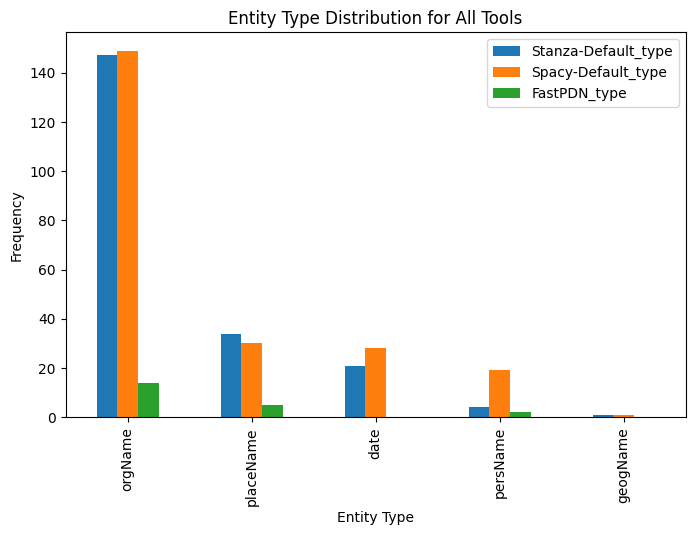

In [37]:
def plot_entity_distribution(df, tool_columns):
    counts_df = pd.DataFrame()
    for tool in tool_columns:
        type_counts = df[tool].value_counts(dropna=True)
        counts_df[tool] = type_counts
    counts_df.fillna(0, inplace=True)
    counts_df.plot(kind='bar', figsize=(8, 5), title='Entity Type Distribution for All Tools')
    plt.xlabel('Entity Type')
    plt.ylabel('Frequency')
    plt.show()

plot_entity_distribution(df_base, tool_columns)

In [38]:
def analyse_conflicts(df, tool_columns):
    df['Combined_Types'] = df[tool_columns].astype(str).agg('-'.join, axis=1)
    conflicts = df['Combined_Types'].value_counts()
    return conflicts

conflicts = analyse_conflicts(df_base, tool_columns)
print("Top 10 Conflicts:")
conflicts.head(10)

Top 10 Conflicts:


Combined_Types
orgName-orgName-nan        125
nan-orgName-nan             21
date-date-nan               20
orgName-nan-nan             20
nan-persName-nan            19
placeName-placeName-nan     17
nan-nan-orgName             12
placeName-nan-nan           11
nan-date-nan                 8
nan-placeName-nan            8
Name: count, dtype: int64

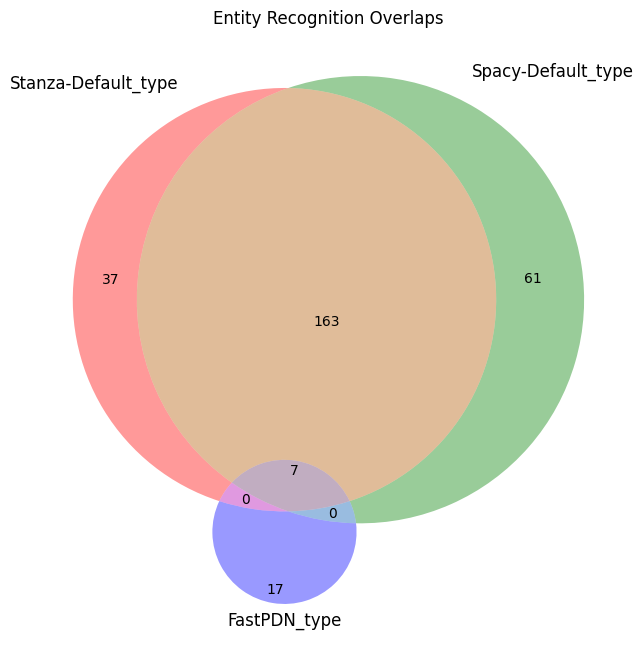

In [39]:
def plot_overlaps(df, tool_columns):
    sets = [set(df[df[tool].notna()].index) for tool in tool_columns]
    plt.figure(figsize=(8, 8))
    venn3(subsets=sets, set_labels=tool_columns)
    plt.title("Entity Recognition Overlaps")
    plt.show()
plot_overlaps(df_base, tool_columns)